# Physics 760: Computational Physics
## WS 2022/23
### Week 3
#### Pugazharasu Anancia Devaneyan, Rishi Kumar Senthil Kumar

In [264]:
#setup the notebook
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import random
import math as mth
import scipy as sp
from scipy import special

Populating the interactive namespace from numpy and matplotlib


C:\Users\pugaz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['number', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Leapfrog Algorithm

In [265]:
def hammy(p,phi,beta,J,h,N):
    #C
    ham = ((p**2)/2) + ((phi**2)/(2*beta*J)) - (N*np.log(2*np.cosh((beta*h)+phi)))
    return ham

In [266]:
def leap(p0,phi0,J,h,beta,N,N_md):
    '''
    An implementation of the Leapfrog algorithm for the EOMs.

    :param elapsed_bake_time: int - baking time already elapsed.
    :return: int - remaining bake time (in minutes) derived from 'EXPECTED_BAKE_TIME'.

    Function that takes the actual minutes the lasagna has been in the oven as
    an argument and returns how many minutes the lasagna still needs to bake
    based on the `EXPECTED_BAKE_TIME`.
    '''
    #Setting up the initial values
    p = 0
    phi = 0
    epsilon = 1/N_md
    
    #Performing the first half step
    p = p0
    phi = phi0 + ((epsilon/2)*p0)
    
    #Iterating through the Ṇ
    for i in range(1,N_md-1):
        p = p - (epsilon*((phi/(beta*(J/N)))-(N*np.tanh((beta*h)+phi))))
        phi += epsilon*p
        
    #Performing the final leap
    p = p - (epsilon*((phi/(beta*(J/N)))-(N*np.tanh((beta*h)+phi))))
    phi += (epsilon/2)*p
    return p,phi

Now we plot for the convergence versus the 

In [268]:
p_leap = 1
phi_leap = 1
J_leap = 0.5
h_leap = 0.2
beta_leap = 0.5
N_leap = 30

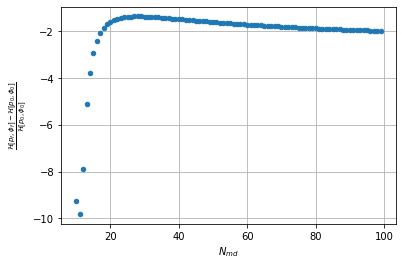

In [269]:
initial_hammy = hammy(p_leap,phi_leap,J_leap,h_leap,beta_leap,N_leap)
N_mds = np.arange(10,100)
y_axis = []

for n in N_mds:
    integ = leap(p_leap,phi_leap,beta_leap,J_leap,h_leap,N_leap,n)
    final_hammy = hammy(integ[0],integ[1],J_leap,h_leap,beta_leap,N_leap) 
    y = (final_hammy-initial_hammy)/initial_hammy
    y_axis.append(y)

plt.plot(N_mds,y_axis,marker='.',markersize=9,linestyle='')
#plt.yscale('log')
plt.xlabel('$N_{md}$')
plt.ylabel('$\\frac{\\mathcal{H}\\left[p_f, \\phi_f\\right]-\\mathcal{H}\\left[p_0, \\phi_0\\right]}{\\mathcal{H}\\left[p_0, \\phi_0\\right]}$')
plt.grid()
plt.savefig('Plots/h_v_n.png',dpi=300, bbox_inches = "tight")

# Hybrid Monte Carlo algorithm

In [270]:
def distribution_function(beta,J,h,N,x):
    J_N = J/N
    fun = np.exp(0.5*(beta*J_N*(x**2))+(beta*h*x))
    return fun

In [7]:
def partition_function(beta,J,h,N):
    Z = 0
    for n in range(N+1):
        current = N-(2*n)
        Z += special.comb(N, n)*distribution_function(beta,J,h,N,current)
    return Z

In [8]:
def exact_energy(beta,J,h,N):
    energy = 0
    Z = partition_function(beta,J,h,N)
    for n in range(N+1):
        current = N-(2*n)
        energy += special.comb(N, n)*((0.5*beta*(J/N)*(current**2)) + (beta*h*current))*distribution_function(beta,J,h,N,current)
    energy = energy*(1/(N*Z))*(-1)    
    return energy

In [9]:
def exact_mag(beta,J,h,N):
    mag = 0
    Z = partition_function(beta,J,h,N)
    for n in range(N+1):
        current = N-(2*n)
        mag += special.comb(N, n)*current*distribution_function(beta,J,h,N,current)
    mag = mag/(N*Z)        
    return mag

In [221]:
def accept_reject(sweeps,p,phi,beta,J,h,N,N_md):
    phi_list = []
    phi_list.append(phi)
    
    new_vars = []
    new_hammy = 0
    
    for i in range(sweeps):
        
        
        init_ham = hammy(p,phi,J,h,beta,N)
        
        new_vars = leap(p,phi,J,h,beta,N,N_md)
        
        new_hammy = hammy(new_vars[0],new_vars[1],J,h,beta,N)
        
        
        rand = np.random.random()
        
        # fill in the metropolis critereon
        if rand<=min(1,np.exp(init_ham - new_hammy)):
            
            #p = random.gauss(0,1)
            p = new_vars[0]
            phi = new_vars[1]
            phi_list.append(new_vars[1])
            
        else:
            p = random.gauss(0,1)
            phi_list.append(phi_list[-1])
        
    return phi_list

In [197]:
def numerical_mag(beta,h,phi_list):
    mag = 0
    beta_h = beta * h
    for phi in phi_list:
        mag += abs(np.tanh((beta_h + phi)))
    mag = mag/(len(phi_list))
    return mag

In [218]:
def numerical_energy(J,h,beta,N,phi_list):
    energy = 0
    for phi in phi_list:
        energy += (1/(2*N*beta)) - ((phi**2)/(2*(beta**2)*J)) - (h*np.tanh((beta*h) + phi))
    energy = energy/(len(phi_list))
    return energy

In [287]:
J_input = np.linspace(0.2,2,100)
N_md = 21
sweeps = N_md*100
site_N = 10
beta = 1
h_fixed = 0.5

In [288]:
initial_phi = 0.5
initial_p = random.gauss(0,1)

In [289]:
m_numeric = []
m_exact = []

for i in J_input:
    field_list = accept_reject(sweeps,initial_p,initial_phi,beta,i,h_fixed,site_N,N_md)
    numeric_mag = numerical_mag(beta,h_fixed,field_list)
    exact_magne = exact_mag(beta,i,h_fixed,site_N)
    m_numeric.append(numeric_mag)
    m_exact.append(exact_magne)

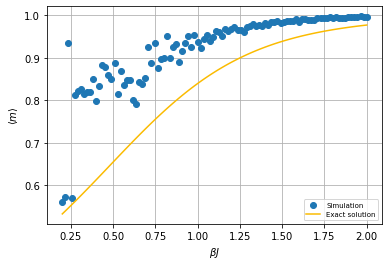

In [292]:
plt.plot((J_input*beta),m_numeric,marker='o',label="Simulation",linestyle='')
plt.plot((J_input*beta), m_exact, color ='#fbbb00', label='Exact solution')

plt.xlabel('$\\beta J$')
plt.ylabel('$\\langle m \\rangle$')
plt.legend(loc='lower right',prop={'size': 7})
plt.grid()
plt.savefig('Plots/m_v_j.png',dpi=300, bbox_inches = "tight")

In [275]:
e_numeric = []
e_exact = []
for i in J_input:
    field_list_2 = accept_reject(sweeps,initial_p,initial_phi,beta,i,h_fixed,site_N,N_md)
    numeric_ene = numerical_energy(i,h_fixed,beta,site_N,field_list_2)
    exact_ene = exact_energy(beta,i,h_fixed,site_N)
    e_numeric.append(numeric_ene)
    e_exact.append(exact_ene)

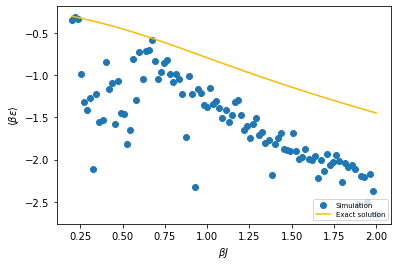

In [280]:
plt.plot((J_input*beta),(e_numeric),marker='o',label="Simulation",linestyle='')
plt.plot((J_input*beta),e_exact, color ='#fbbb00', label='Exact solution')

plt.xlabel('$\\beta J$')
plt.ylabel('$\\langle \\beta \\epsilon \\rangle$')
plt.legend(loc='lower right',prop={'size': 7})
plt.grid()
plt.savefig('Plots/e_v_j.png')

Now we try to plot for the acceptance rate.

In [284]:
acceptance_rate = []
Nmd = np.linspace(10,100,100,dtype=int)
for number in Nmd:
    acceptance_rate.append((len(list(set(accept_reject(sweeps,initial_p,initial_phi,beta,0.5,h_fixed,site_N,number))))/number)*100)

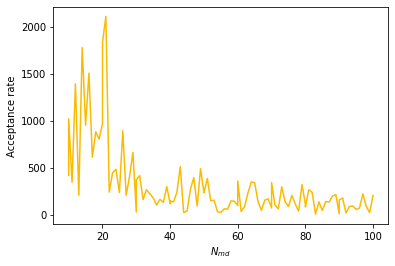

In [285]:
plt.plot(Nmd, acceptance_rate, color ='#fbbb00')

plt.xlabel('$N_{md}$')
plt.ylabel('Acceptance rate')
plt.savefig('Plots/acc.png',dpi=300, bbox_inches = "tight")

In [286]:
display(Nmd[np.argmax(acceptance_rate)])

21